In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
import katpoint

In [4]:
ant = katpoint.Antenna('ant1, -30:43:17.3, 21:24:38.5, 1038.0, 12.0, 18.4 -8.7 0.0, -0:05:30.6 0 -0:00:03.3 0:02:14.2 0:00:01.6 -0:01:30.6 0:08:42.1, 1.22')
cat2 = katpoint.Catalogue(antenna = ant,add_specials=True)
sun = cat2.lookup['sun']
moon = cat2.lookup['moon']

start_timestamp = katpoint.Timestamp('2016-10-12 22:00:00')
start_epoch = start_timestamp.secs


font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 24,
        }

In [5]:
# Comm observation table:
# JIRA, Description, Start LST, End LST, Obs duration, Cadance, Allocated time
sources = [['None', 'Maintenace',0.00,0.00,24,24*6,1000],
    ['MKAIV-231','PSR timing and morphology - Hi LST',16.00,20.50,2,24*3,100],
    ['MKAIV-231','PSR timing and morphology - Lo LST',1.50,10.00,2,24*3,100],
#
    ['MKAIV-348','Field with significant ancillary data. (EQU_COMM_TEST)',18.75,3.50,9,24*13,100],
    ['COMM-53','Calibrator switching effects',16.50,4.00,10,24*13,100],
    ['COMM-58','Mosaicing',19.42,8.00,11,24*13,100],
    ['MKAIV-229','Full pol beam correction',13.50,1.50,10,24*13,100],
    ['MKAIV-347','SCP Imaging',0.00,0.00,12,24*13,100],
    ['COMM-58','Continuum sensitivity (Deep2)',19.00,10.50,12,24*13,100],
    ['COMM-155','Polarization purity and leakage (BP pol)',23.00,16.50,12,24*13,100],
    ['COMM-155','Polarization purity and leakage (k-cross)',22.00,16.00,12,24*13,100],
    ['COMM-160','Spectral dynamic range',9.67,23.00,12,24*13,100],
    ['COMM-154','Spectral line sensitivity (PKS 1814-63)',13.00,1.50,12,24*13,100],
    ['COMM-158','Image bright HI source (NGC 3621)',5.50,16.92,12,24*13,100],
    ['COMM-159','NGC 5236 / M83',6.83,18.50,12,24*13,100],
    ['COMM-161','Image faint extended HI (IC 5264)',17.25,4.67,12,24*13,100],
    ['COMM-157','Image HI with extended strong continuum (Cen A)',7.42,19.42,12,24*13,100],
#
    ['MRTS-167','Test 2.2 Tsys and Tnd',-24.00,-24.00,1,24*6,100],
    ['COMM-47','Position determination, Cable lengths',0.00,0.00,6,24*4.25,100],
    ['MRTS-171','Test 2.7 Pointing (L & Ku band)',0.00,0.00,6,24*4.25,100],
    ['MRTS-169','Test 2.5 Gain Stability',0.00,0.00,10,24*6,100],
    ['COMM-156','Spectral leakage characterization',22.00,10.00,1,24*29,100],
    ['MRTS-166','Test 2.1 Tipping Curve',0.00,0.00,1,24*13,100],
    ['MRTS-168','Test 2.4 Gain Curve (Ku band) Now at L-Band',-24.00,-24.00,12,24*13,100],
    ['MKAIV-308','Basic functionality test',7.42,19.42,1,24*6,100],
    ['MKAIV-295','checking calibrators',0.00,0.00,6,24*4.3,100]]

sources = [[i]+s for i,s in enumerate(sources)]


In [6]:
days = 60
stp = 3600.
t = start_epoch + np.arange(0, 24. * 60. * 60. * days, stp)
o = zeros_like(t)
    
x = epoch2num(t)
el_limit = 20
sun_limit = 0
leg = [0]
for j,jira,descrip,lst_start,lst_end,duration,cadance,alloc  in sources:
    mode = 'day'
    block = 0 # the option to schedule in blocks is not needed for AR1
    # the algoritm below determines the ra,dec for a "source" 
    # that meets the scheduling criteria ... some tests have more than
    # one target but the start and end LST are known 
    if lst_end < lst_start:
        win = 24 - lst_start + lst_end
        ra = (lst_start + win/2) * 15
        if ra > 360:
            ra = ra - 360
        win = win * 12
        dec_res =  degrees(arctan((win * tan(radians(76))/120) + tan(radians(-75)))) * -60./75 - 15
    elif lst_end > lst_start:
        win = lst_end - lst_start
        ra = (lst_start + win/2) * 15
        win = win * 12
        dec_res =  degrees(arctan((win * tan(radians(76))/120) + tan(radians(-75)))) * -60./75 - 15
    elif lst_start == lst_end:
        ra = 0
        dec_res = -90
    tar = katpoint.construct_radec_target(radians(ra),radians(dec_res))
    targets = [tar]
    leg.append(j+1)
    
    for target in targets:
        target.antenna = ant
        t_elev = katpoint.rad2deg(target.azel(t)[1])
        sun_elev = katpoint.rad2deg(sun.azel(t)[1])
        # create an array of all the times when the source is observable 
        if mode == 'night':
            obs = (sun_elev < sun_limit) & ( t_elev > el_limit)
        elif mode == 'day_only':
            obs = (sun_elev > sun_limit) & ( t_elev > el_limit)
        else:
            obs = ( t_elev > el_limit)
        if jira == 'MRTS-167':
            t_elev = katpoint.rad2deg(moon.azel(t)[1])
            sep = katpoint.rad2deg(moon.separation(sun))
            obs = (sep > 10) & ( t_elev > el_limit)
        cnt = 0
        i = 0
        block_c = block
        N = obs.shape[0]
        slots = []
        # cycle through the observable array and based on duration,cadance and block
        # you schedule the times
        while True:
            if all(obs[i:i+duration]) and (sum(o[i:i+duration])==0): # is the source observable and the time is not 
                if (alloc > duration):                               # yet allocated to anything else
                    o[i:i+duration] = j+1
                    alloc -= duration
                    i = i + duration -1 + cadance
                elif (sum(o[i:i+alloc])==0):
                    o[i:i+alloc] = j+1
                    break
            if i >=N-1:
                break
            i += 1
            


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


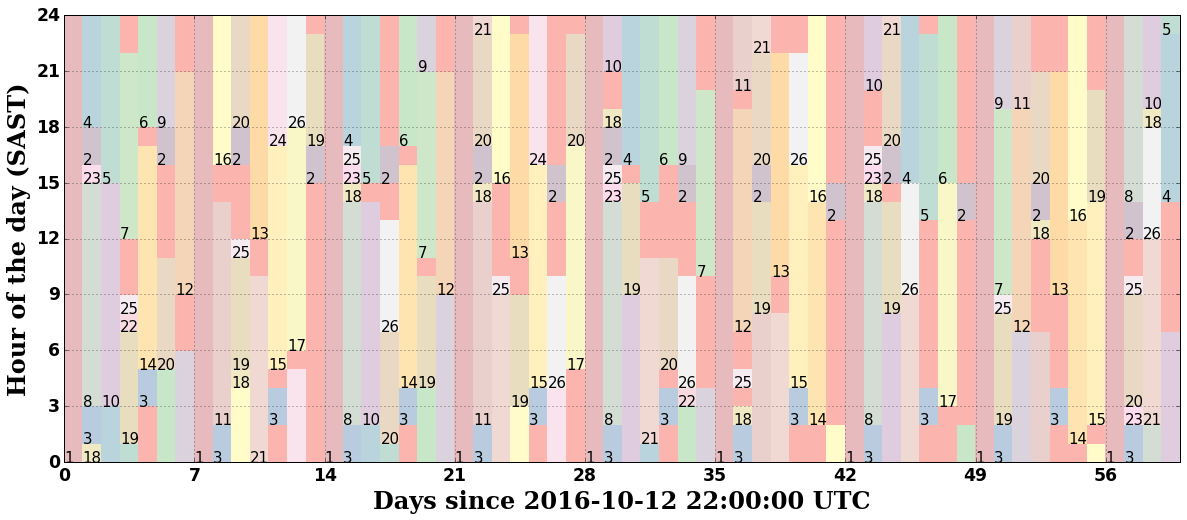

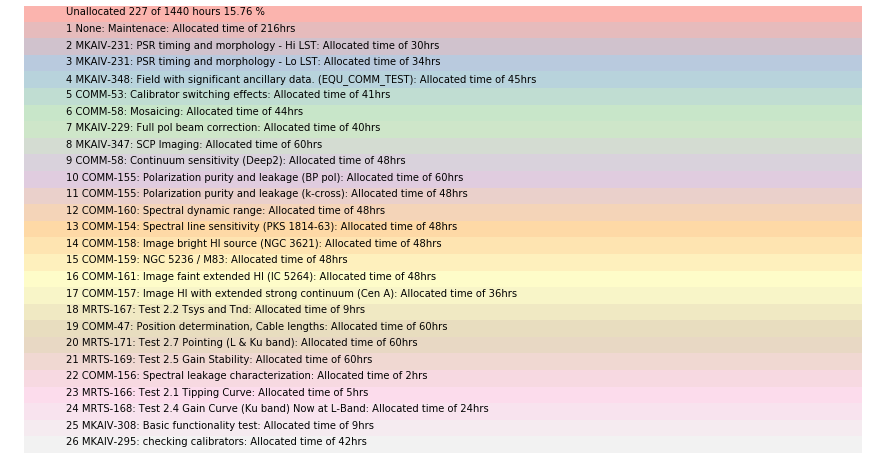

In [7]:
c = 'Pastel1'
n = reshape(o,[days,24])
figure(figsize=(20,8))
pcolormesh(n.T,cmap=c)
ylabel('Hour of the day (SAST)', fontdict=font)
xlabel('Days since %s'%start_timestamp.local(), fontdict=font)
yticklabels = getp(gca(), 'yticklabels')
setp(yticklabels, fontsize='xx-large',weight='bold')
xticklabels = getp(gca(), 'xticklabels')
setp(xticklabels, fontsize='xx-large',weight='bold')
grid()
for s in sources:
    ind = o == s[0]+1
    tmp = diff(ind.astype(int))
    w = where(tmp == 1)
    if w[0].shape[0] == 0:
        continue
    x_1,y_1 = unravel_index(w[0],[days,24])
    #print x_1,y_1
    for i in range(len(x_1)):
        x = x_1[i]
        y = y_1[i]
        if y == 23:
            x +=1
            y = -1
        text(x,y+1,str(s[0]+1),fontsize=15) 
text(0,0,'1',fontsize=15)
yticks(range(0,25,3))
xticks(range(0,62,7))
ylim(0,24)



figure(figsize=(15,8))
imshow(array((leg,leg)).T,interpolation='nearest',aspect='auto',cmap=c)
for i,jira,descrip,lst_start,lst_end,duration,cadance,alloc in sources:
    name = descrip
    proj = jira
    cnt = sum(o == i+1)
    text(-0.4,i+1,str(i+1)+" "+proj+': '+name+': Allocated time of '+str(cnt)+'hrs')
cnt = o == 0
text(-0.4,0,'Unallocated %d of %d hours %2.2f %%'%(sum(cnt),days*24,sum(cnt)/(days*24.) * 100.))
ax = gca()
ax.set_axis_off()


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


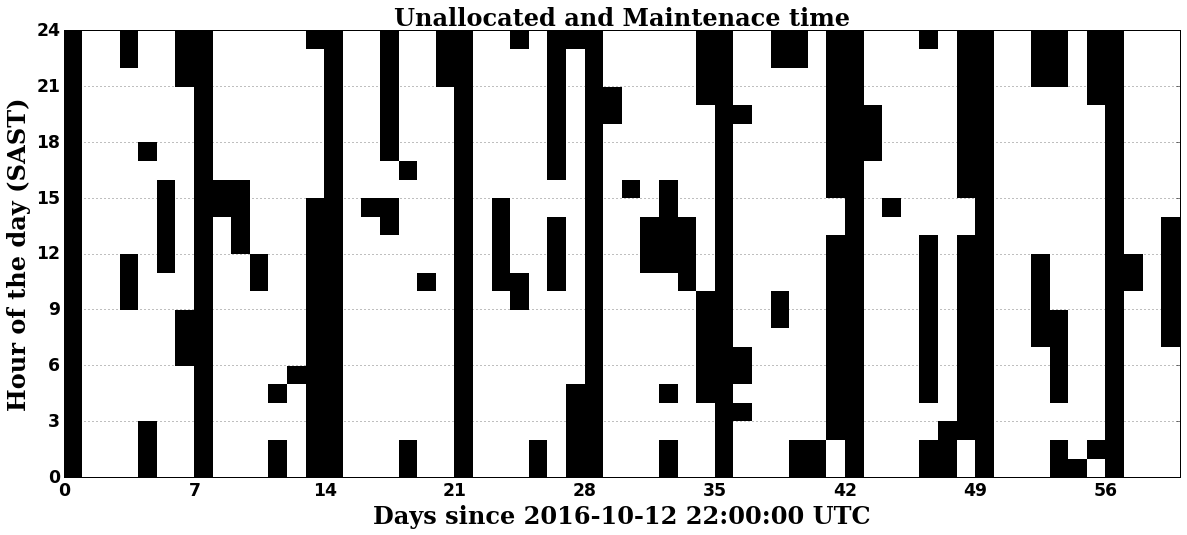

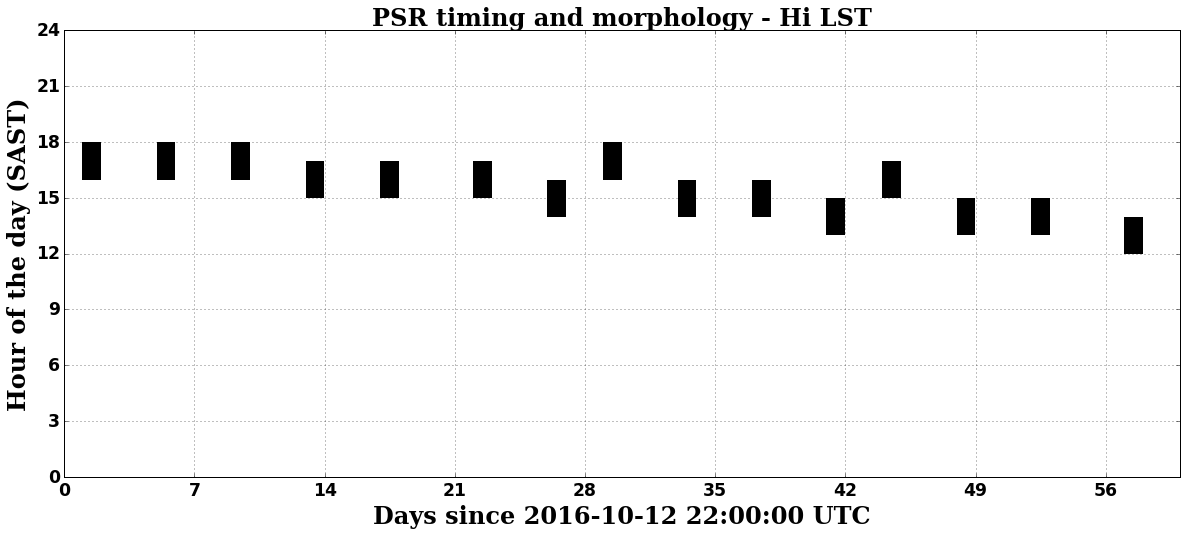

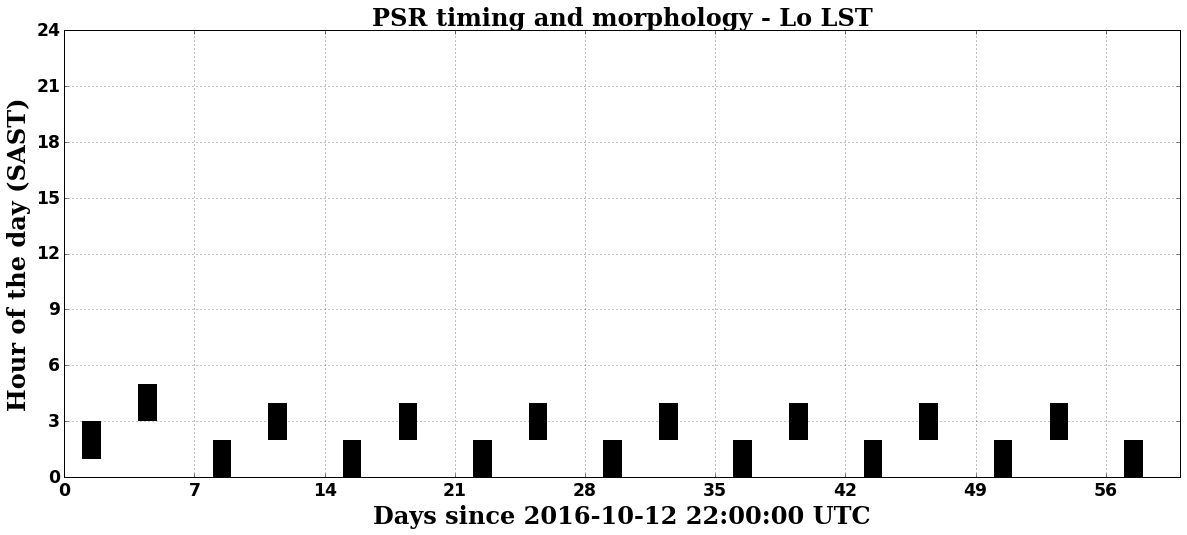

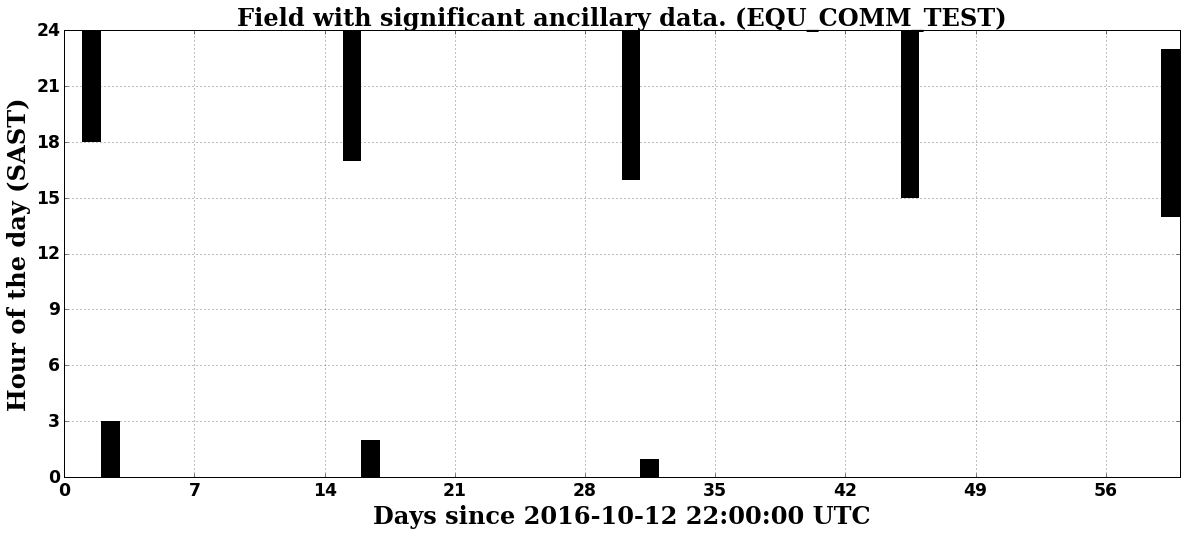

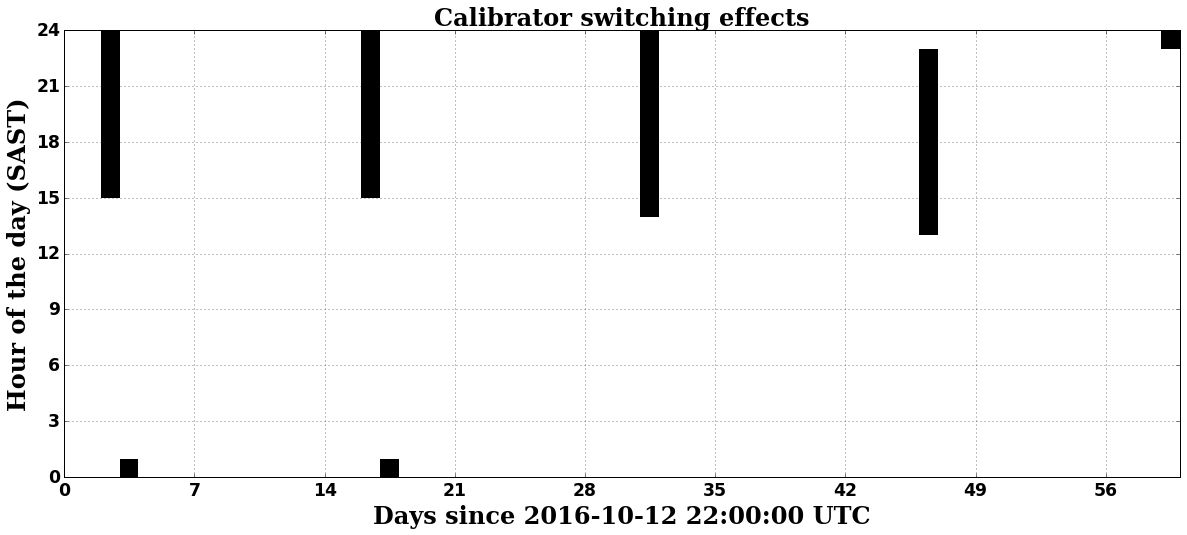

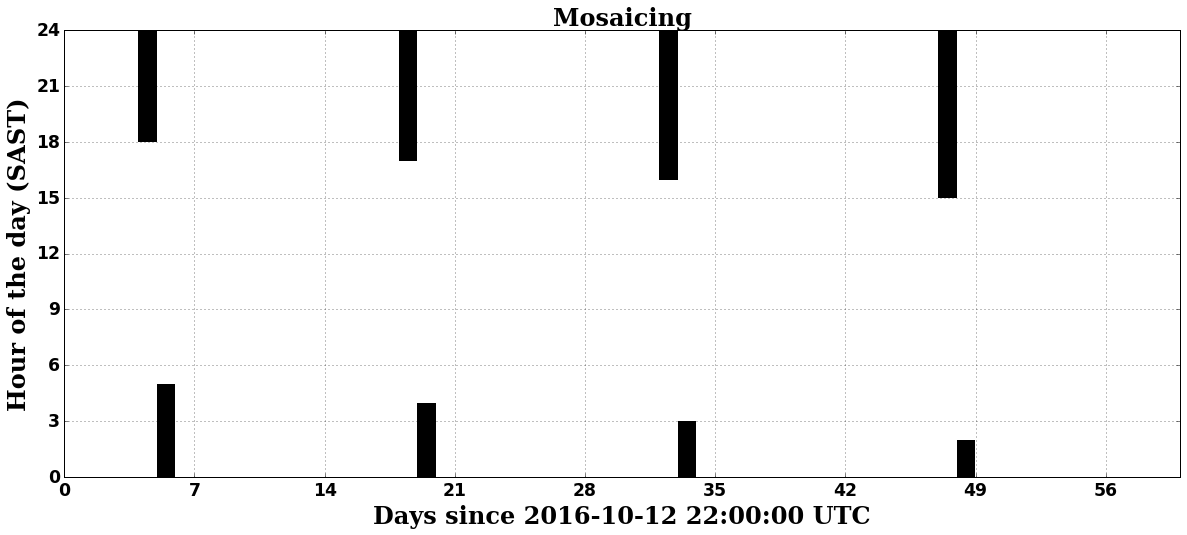

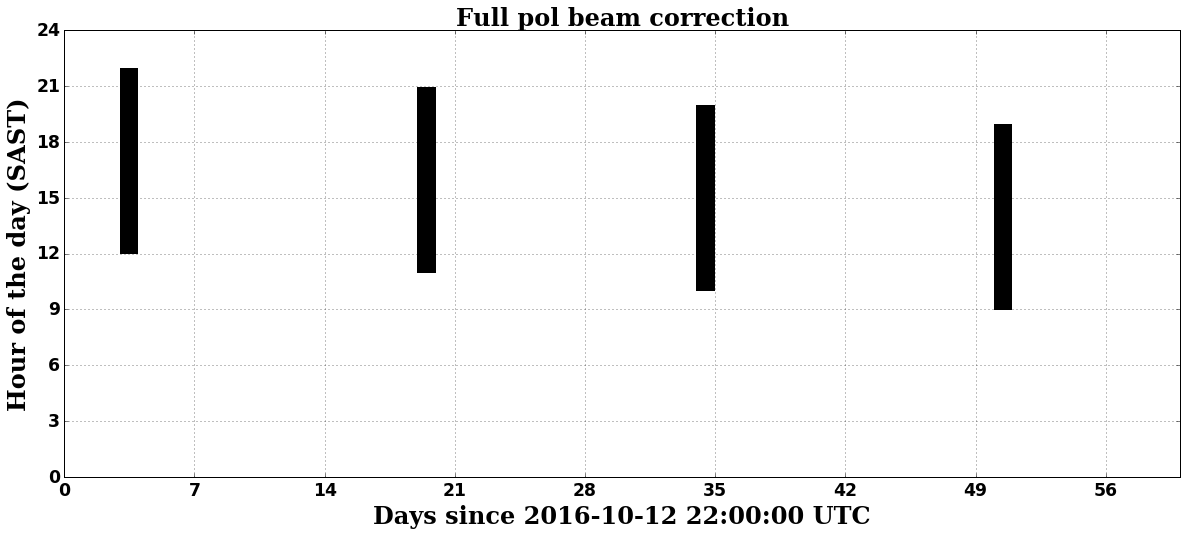

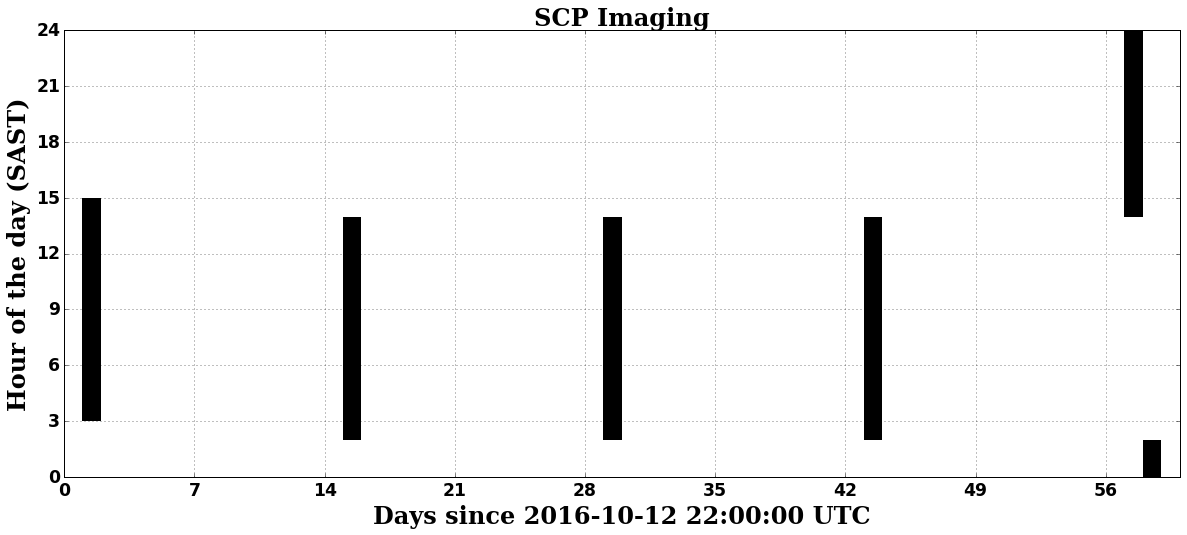

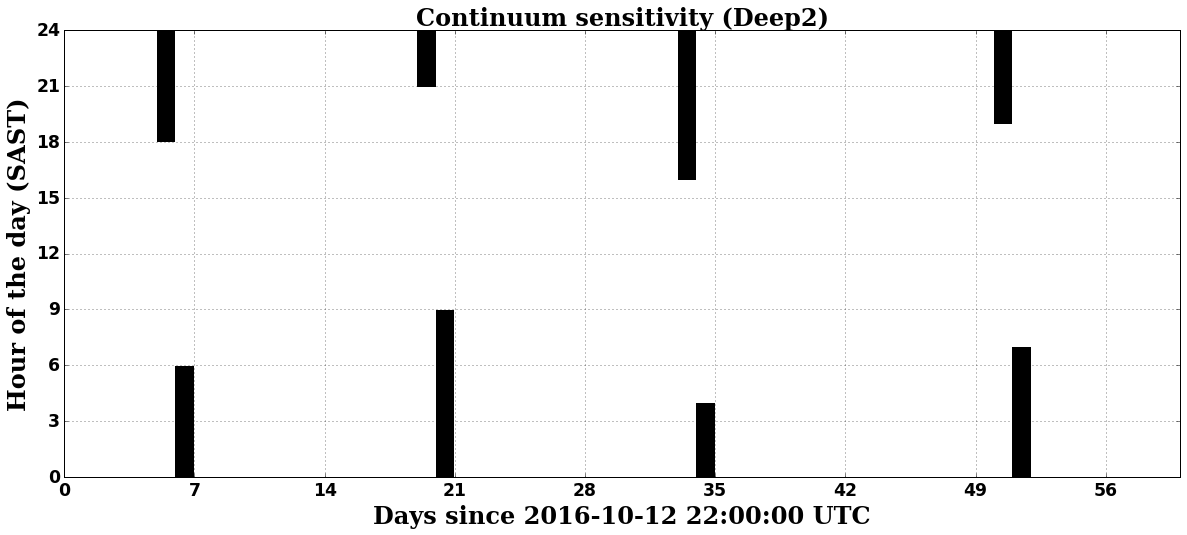

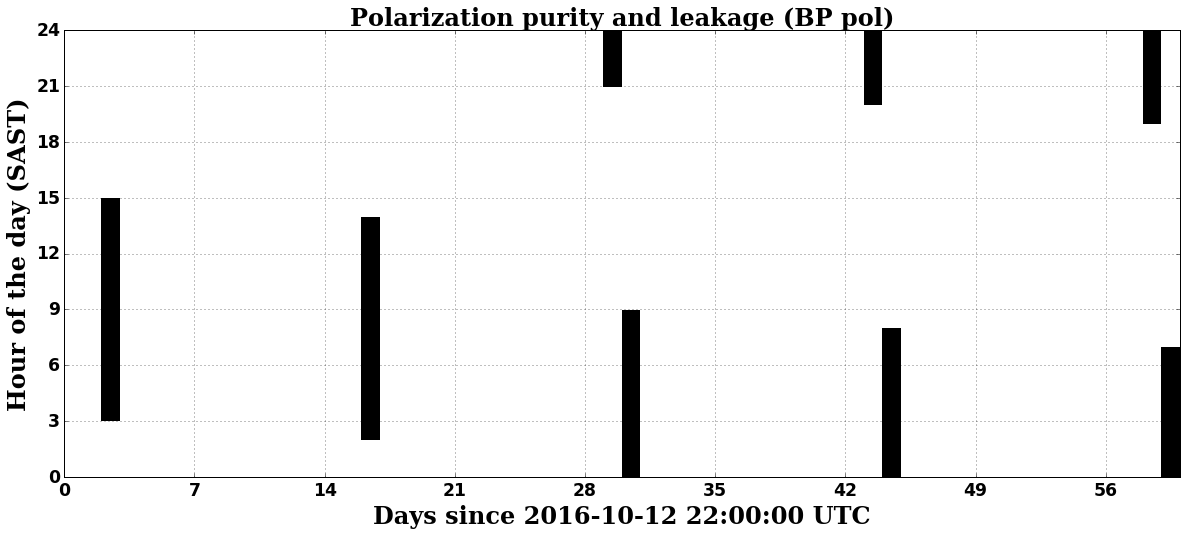

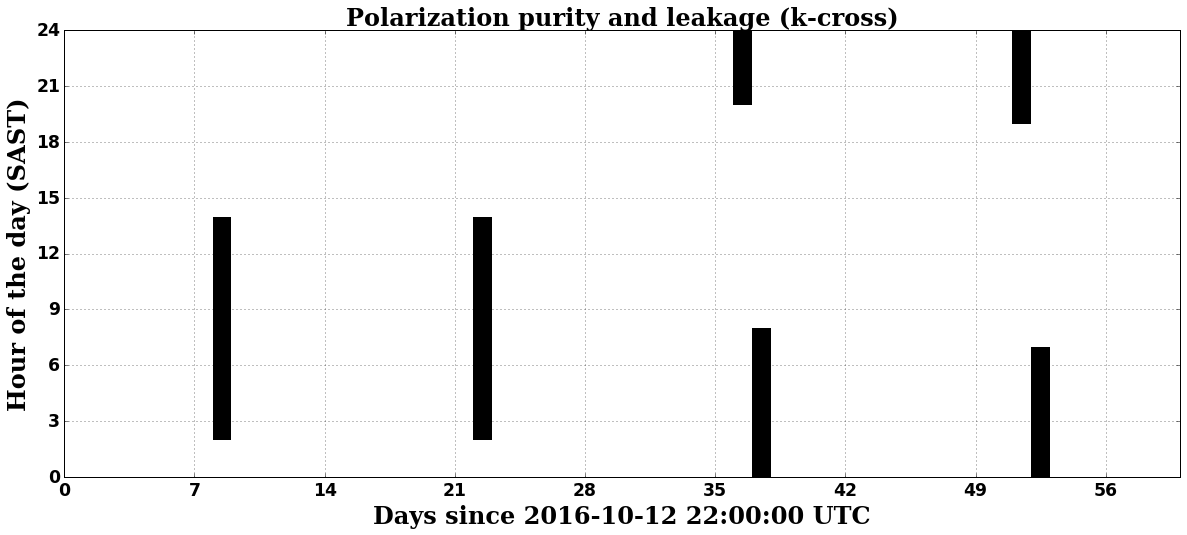

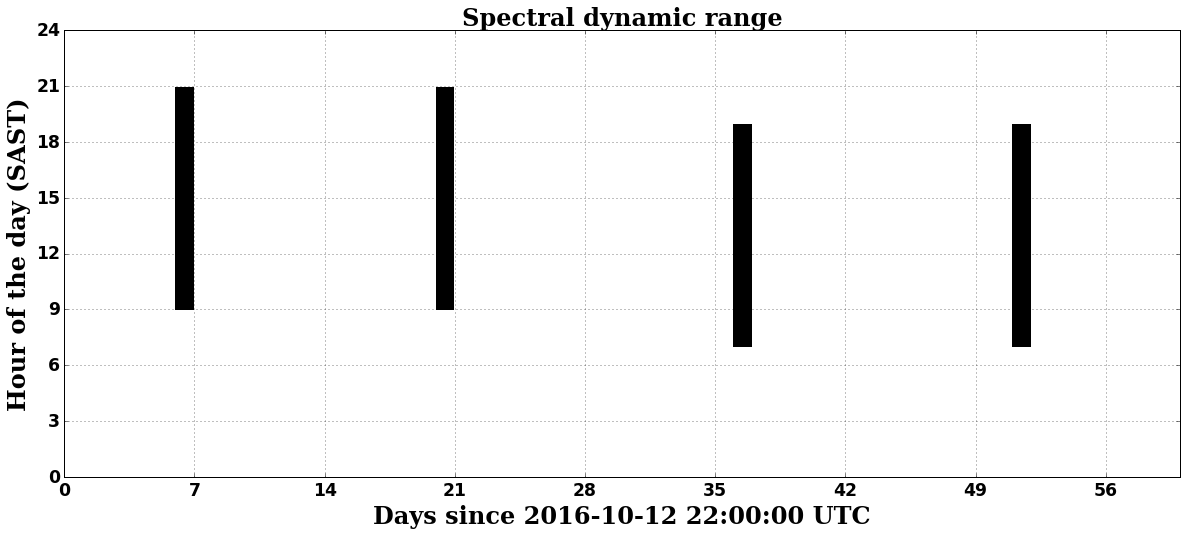

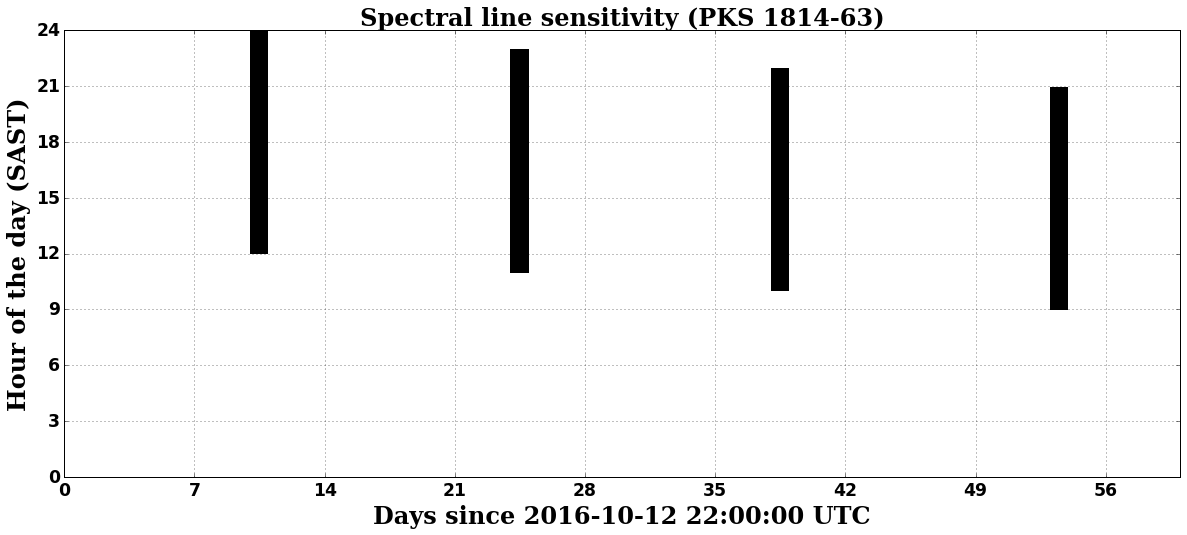

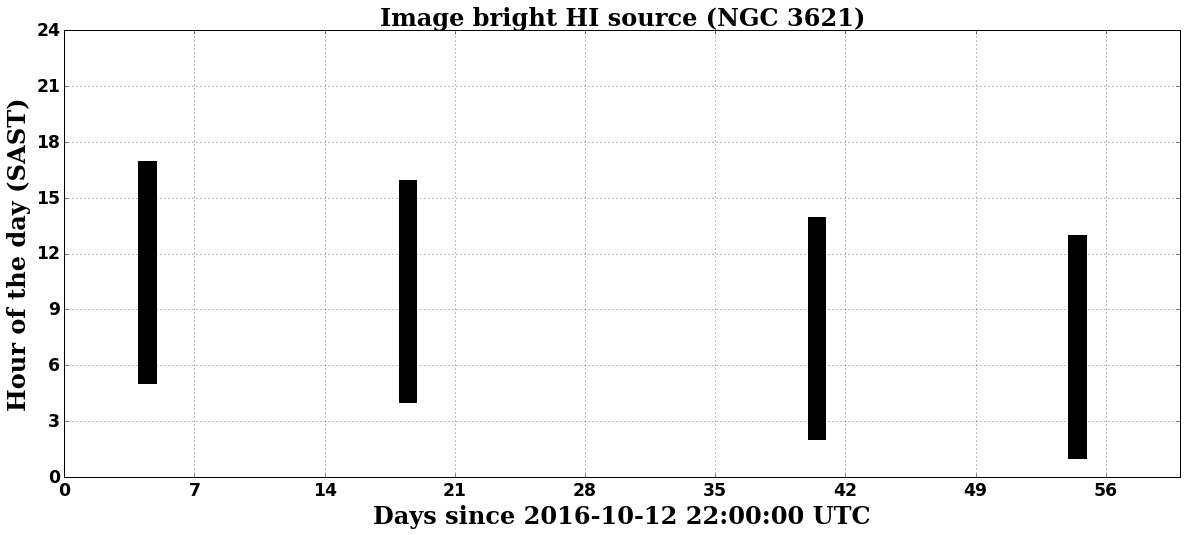

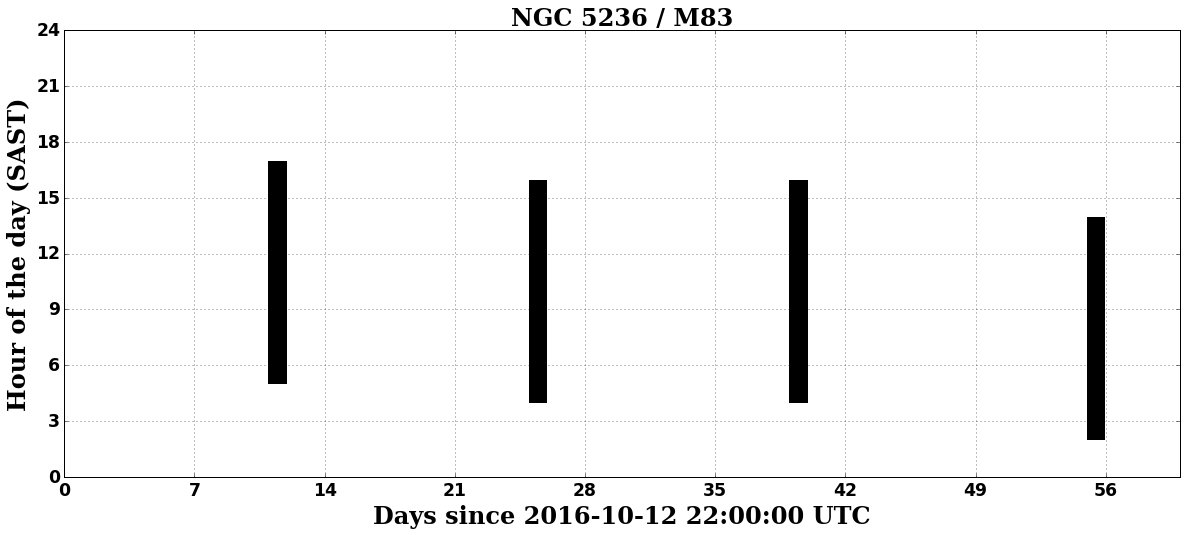

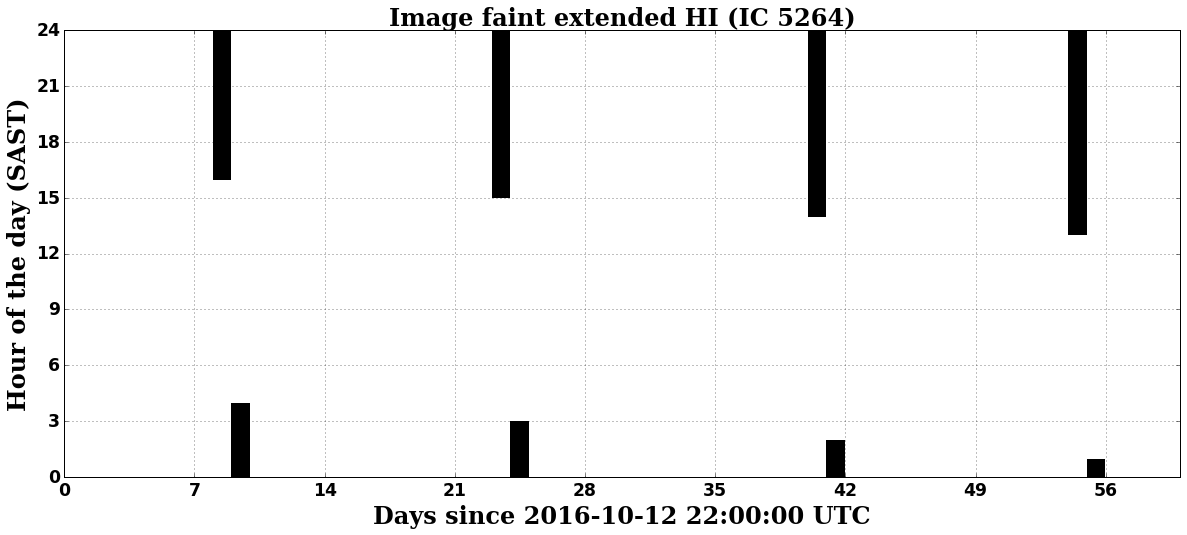

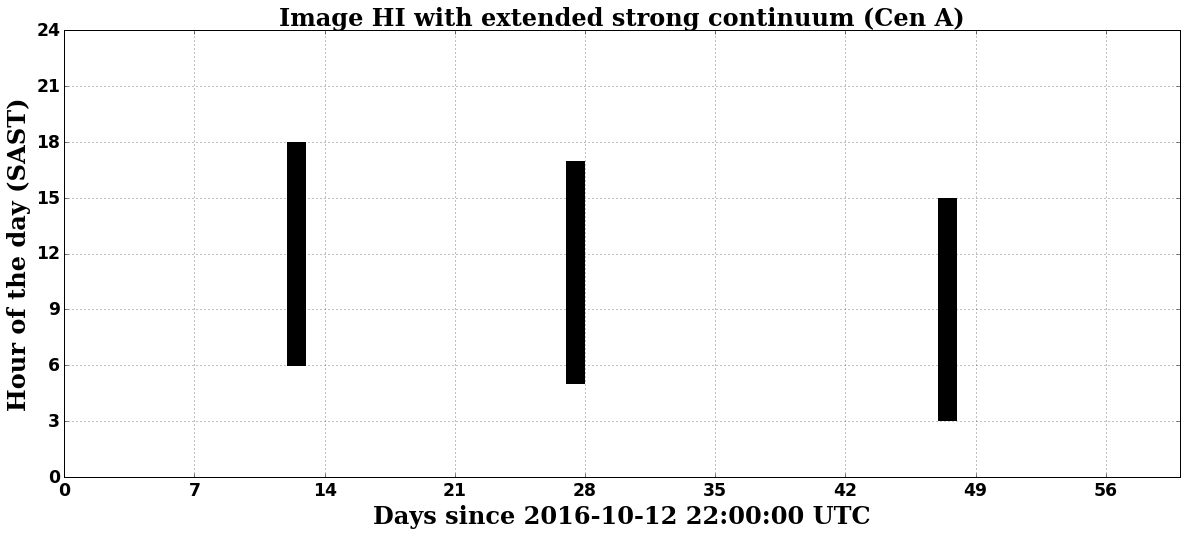

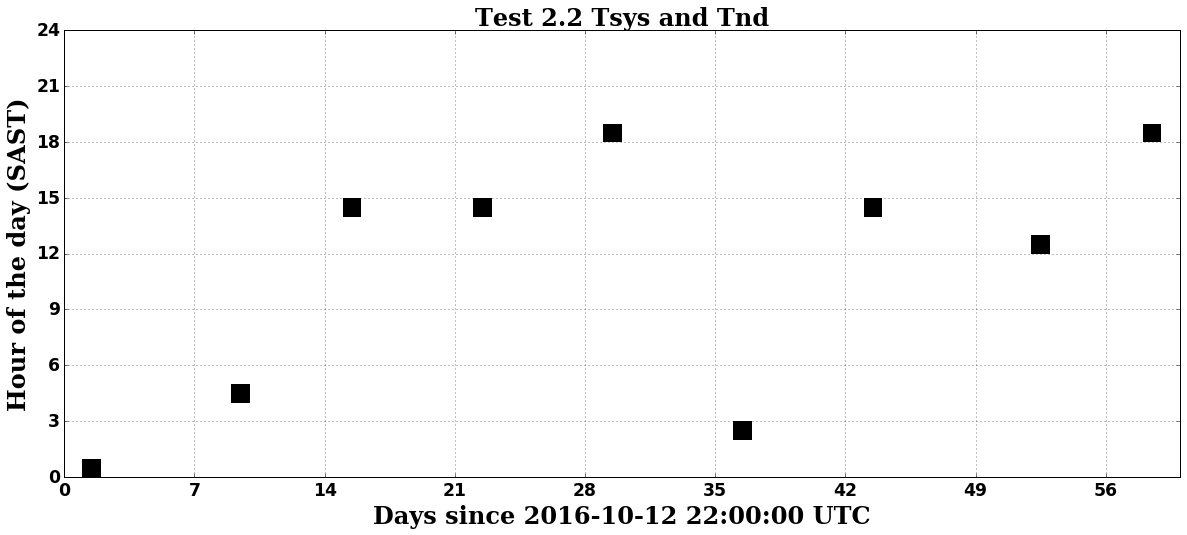

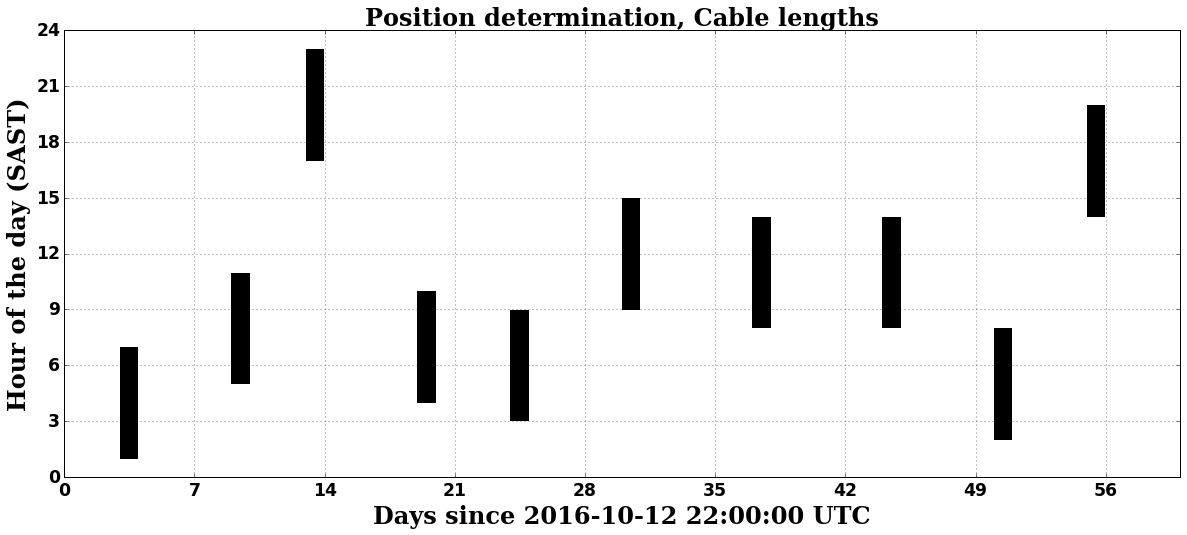

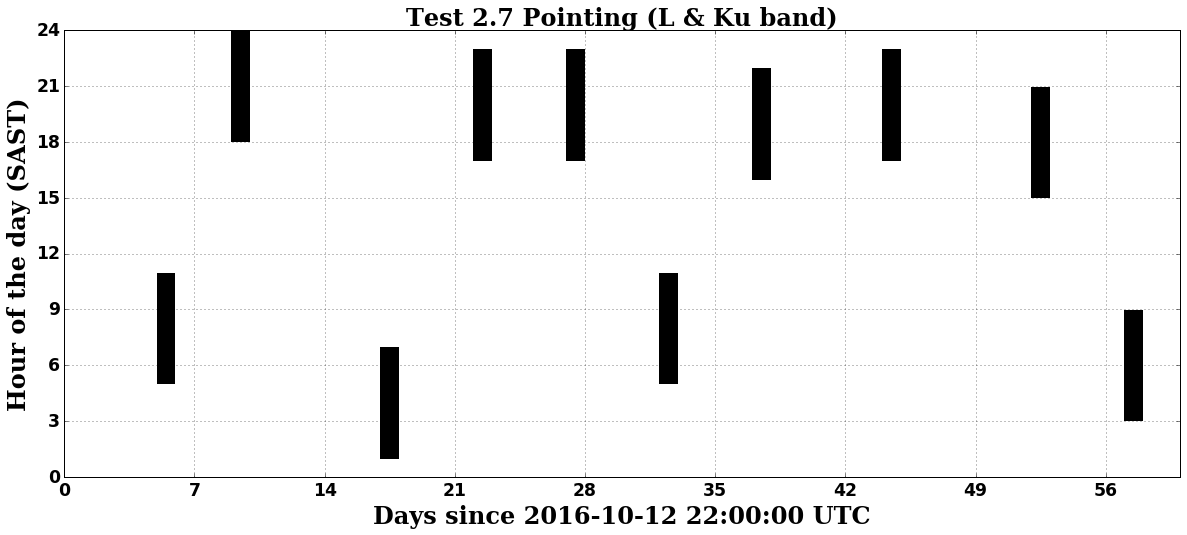

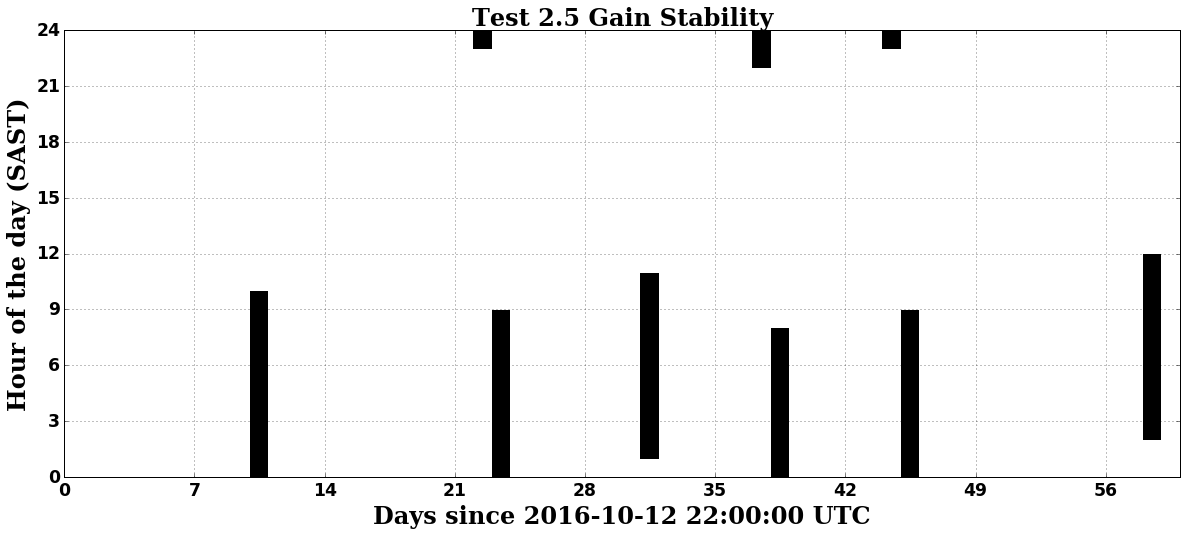

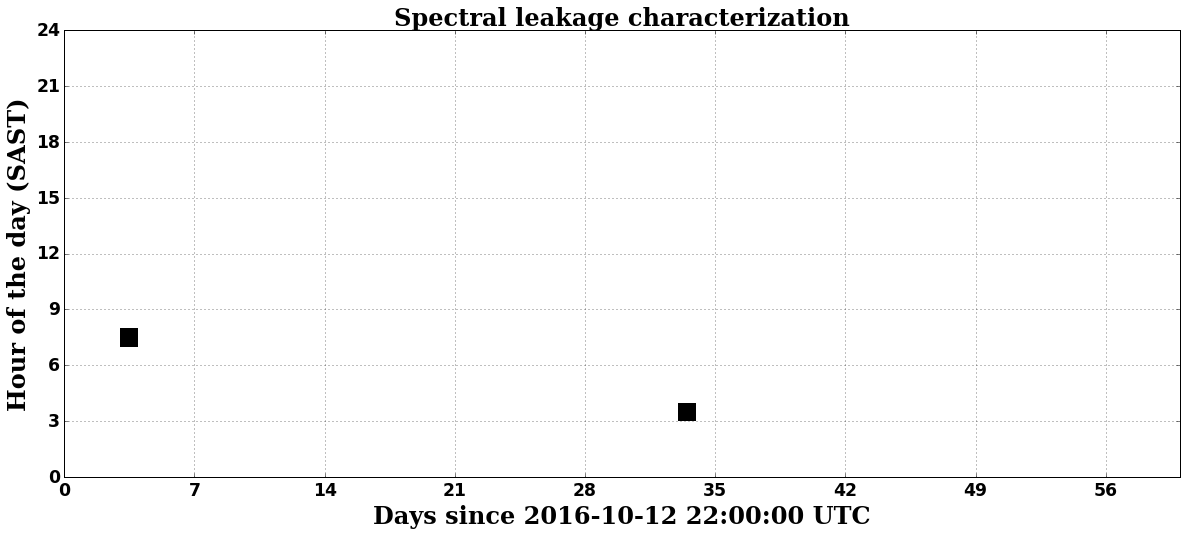

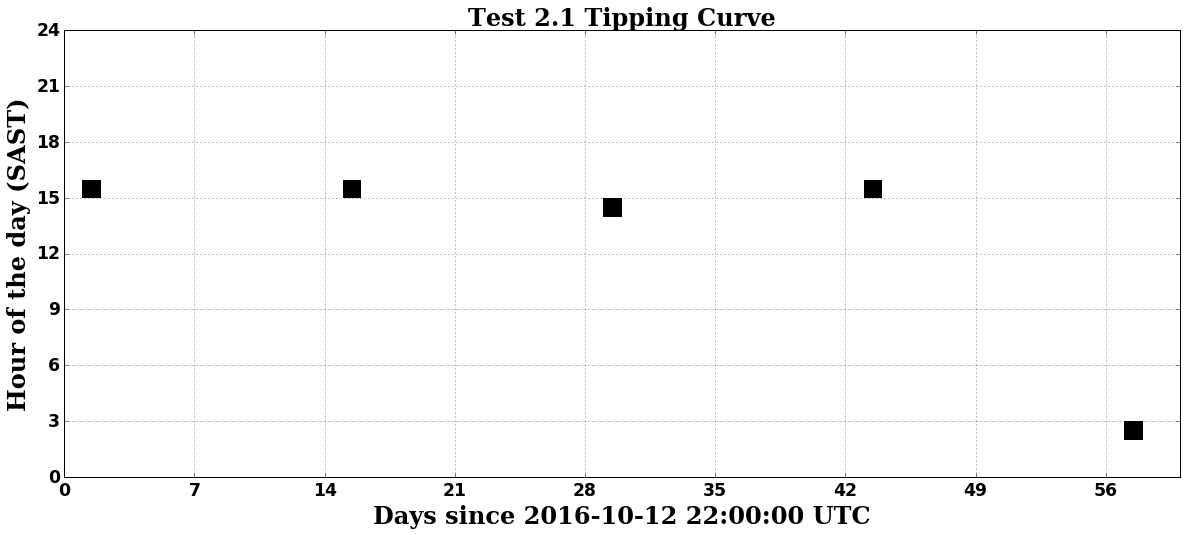

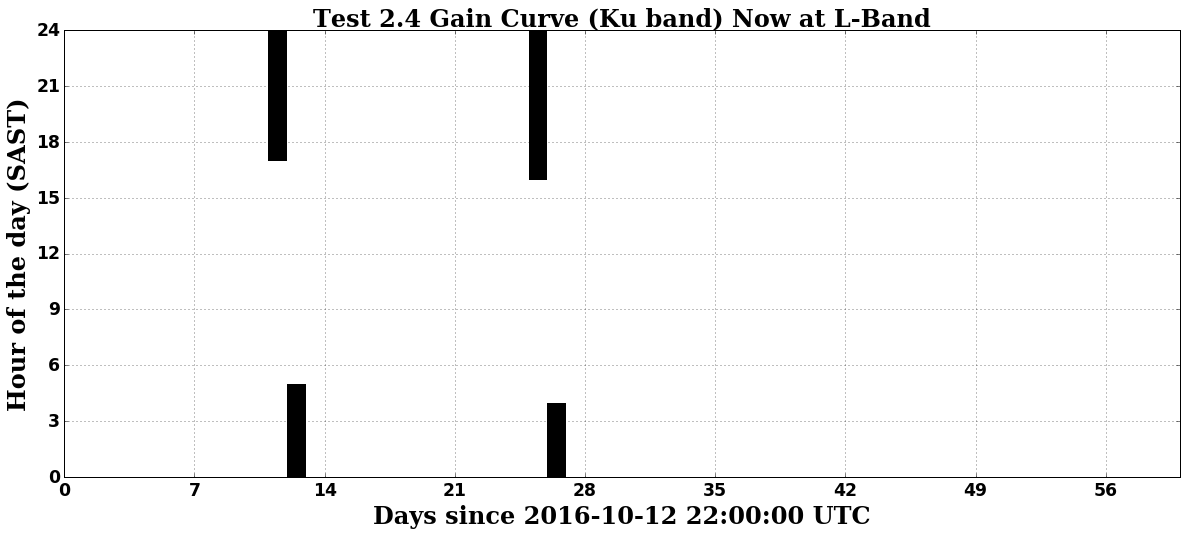

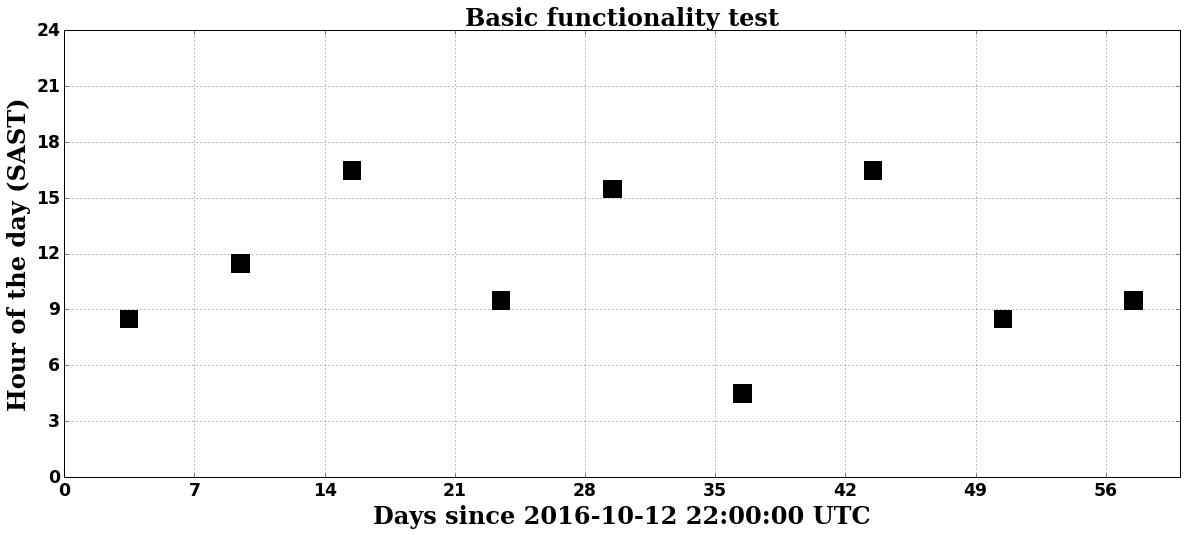

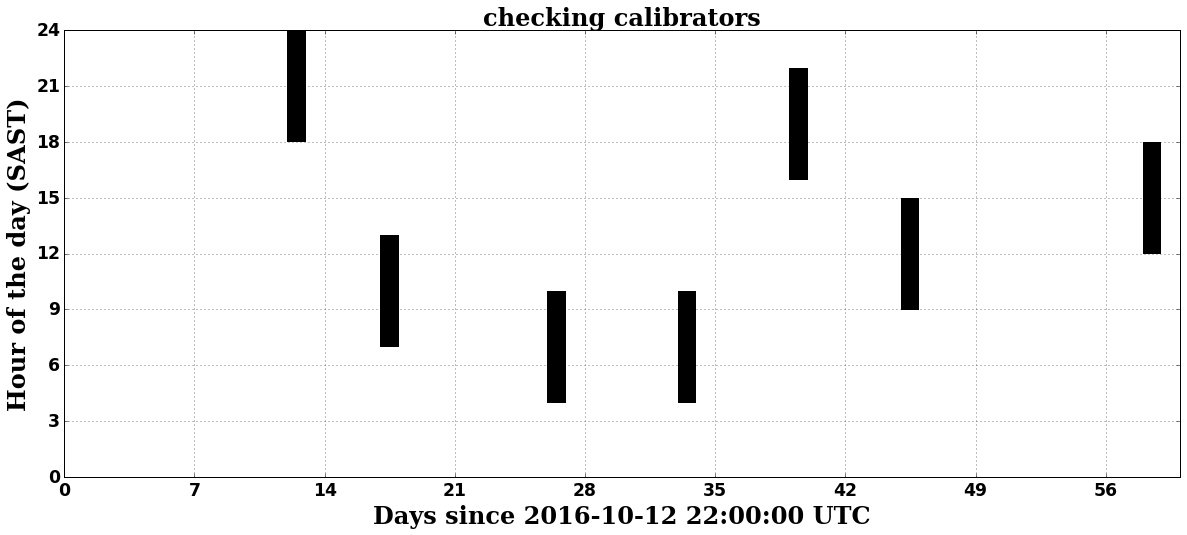

In [8]:
# for un allocated time
figure(figsize=(20,8))
pcolormesh((n.T == 0) | (n.T == 1) ,cmap='Greys')
ylabel('Hour of the day (SAST)', fontdict=font)
xlabel('Days since %s'%start_timestamp.local(), fontdict=font)
yticklabels = getp(gca(), 'yticklabels')
setp(yticklabels, fontsize='xx-large',weight='bold')
xticklabels = getp(gca(), 'xticklabels')
setp(xticklabels, fontsize='xx-large',weight='bold')
title('Unallocated and Maintenace time', fontdict=font)
grid()
yticks(range(0,25,3))
xticks(range(0,62,7))
ylim(0,24)

# for the observation sources
for s in sources[1:]:
    figure(figsize=(20,8))
    pcolormesh(n.T == s[0]+1,cmap='Greys')
    ylabel('Hour of the day (SAST)', fontdict=font)
    xlabel('Days since %s'%start_timestamp.local(), fontdict=font)
    yticklabels = getp(gca(), 'yticklabels')
    setp(yticklabels, fontsize='xx-large',weight='bold')
    xticklabels = getp(gca(), 'xticklabels')
    setp(xticklabels, fontsize='xx-large',weight='bold')
    title(s[2], fontdict=font)
    grid()
    yticks(range(0,25,3))
    xticks(range(0,62,7))
    ylim(0,24)



In [9]:
print "Observation calendar for the next %d days after:\n%s\n----------------"%(days,start_timestamp.local())
last = 0
for i,proj in enumerate(o):
    if proj == 0:
        last = proj
        continue
    day,hr = unravel_index(i,[days,24])
    start = start_timestamp + (day * 24 + hr) * 3600
    if hr == 2:
        print "\n\n**********  %s  (%d) **************"%(start.local().split(' ')[0],day)
    if proj != last:
        
        s = sources[int(proj-1)]
        
        end = start + s[5] * 3600
        print '%s: %s slot starts at %s for %d hrs'%(s[1],s[2],start.local(),s[5])
        last = proj

Observation calendar for the next 60 days after:
2016-10-12 22:00:00 UTC
----------------
None: Maintenace slot starts at 2016-10-12 22:00:00 UTC for 24 hrs


**********  2016-10-13  (0) **************
MRTS-167: Test 2.2 Tsys and Tnd slot starts at 2016-10-13 22:00:00 UTC for 1 hrs
MKAIV-231: PSR timing and morphology - Lo LST slot starts at 2016-10-13 23:00:00 UTC for 2 hrs


**********  2016-10-14  (1) **************
MKAIV-347: SCP Imaging slot starts at 2016-10-14 01:00:00 UTC for 12 hrs
MRTS-166: Test 2.1 Tipping Curve slot starts at 2016-10-14 13:00:00 UTC for 1 hrs
MKAIV-231: PSR timing and morphology - Hi LST slot starts at 2016-10-14 14:00:00 UTC for 2 hrs
MKAIV-348: Field with significant ancillary data. (EQU_COMM_TEST) slot starts at 2016-10-14 16:00:00 UTC for 9 hrs


**********  2016-10-15  (2) **************
COMM-155: Polarization purity and leakage (BP pol) slot starts at 2016-10-15 01:00:00 UTC for 12 hrs
COMM-53: Calibrator switching effects slot starts at 2016-10-15 13